In [1]:
import math
import tqdm
import random
import heapq

# import feature_generators
# import timeseries

import pandas as pd
import numpy as np
import scipy as sp

from collections import defaultdict
from datetime import datetime
from itertools import product

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import LinearSVC, SVC

# np.random.seed(42)
# random.seed(a=472443)

# From http://s.arboreus.com/2009/04/cyrillic-letters-in-matplotlibpylab.html
# from matplotlib import rc
# rc('font',**{'family':'serif'})
# rc('text', usetex=True)
# rc('text.latex',unicode=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')

import pcst_fast

In [2]:
class SeedStorage:
    def __init__(self, seed=None):
        self.seed = seed
    def __call__(self):
        if self.seed is None:
            seed = None
        else:
            seed = self.seed
            self.seed += 1
        return seed

# А теперь восстановление матриц суперпозиций

Нам понадобится:
    - Функция их порождения для набора заданных арностей. Инит функция - есть всегда (выделенный корень)
    - 3-4 способа восстановления
    - Собственно генерация набора арностей, набора $N$ матриц корректных суперпозиций, зашумление
    - Восстановление (способами определенными выше), подсчет числа правильно восстановленных

##### Функция порождения и зашумления для набора арностей

In [3]:
def MakeRandomCorrectAdjMatrix(arities, var_number, complexity_limit=-1):
    '''
    Creates a random matrix given vertices arities (root is added)
    
    Parameters
    -------------------------------------------------
    arities:
        list of integers - arities of corresponding functions
    
    var_number:
        number of variables (x,y,...)

    complexity_limit:
        Specifies the depth of a function complexity (max depth from root)
    '''
    func_num = 1 + len(arities)
    total_num = func_num + var_number
    
    arities = [1] + arities + [0] * var_number
    
    queue = [(0, 0)]

    adj_matrix = np.zeros((func_num, total_num))
    
    var_set = set(range(total_num)) - set(range(func_num))
    not_used = set(range(func_num)) - set([queue[0][0]])
            
    while not len(queue) == 0:
        func =  queue[0][0]
        cmplx = queue[0][1]
        func_arity = arities[func]

        chosen = []
        if (cmplx < complexity_limit or complexity_limit == -1):
            if len(not_used) >= func_arity:
                chosen = random.sample(not_used, func_arity)
            else:
                chosen = random.sample(not_used, len(not_used))

        # print(var_set)
        while len(chosen) < func_arity:
            chosen.append(random.sample(var_set, 1)[0])

        for chosen_elem in chosen:
            if chosen_elem < func_num + 1:
                not_used = not_used - set([chosen_elem])
                queue.append((chosen_elem, cmplx + 1))
            adj_matrix[queue[0][0], chosen_elem] = 1
        queue[:] = queue[1:]
    return adj_matrix

def AddNoiseToMatrix(matrix, noise_level=0,
                     noise_variant='uniform', calibration_variant='sigmoid'):
    '''
    Adds noise to matrix
    
    Parameters
    -------------------------------------------------
    matrix:
        0-1 matrix with dtype=int 
    
    noise_level:
        used as parameter for chosen variant

    noise_variant:
        Specifies the variant of noise
        noise_variant == 'uniform':
            noisy_matrix = matrix + np.random.uniform(low=-noise_level, high=noise_level)
        noise_variant == 'normal':
            noisy_matrix = matrix + np.random.normal(scale=noise_level)
    calibration_variant:
        Specifies the variant of caluibration
        calibration_variant == 'sigmoid':
            return(1 / (1 + np.exp(-noisy_matrix)))
        calibration_variant == 'linear':
            noisy_matrix -= noisy_matrix.min()
            noisy_matrix = noisy_matrix / noisy_matrix.max()
            return(noisy_matrix)
        
    '''
    noisy_matrix = matrix.copy()
    if noise_variant == 'uniform':
        noisy_matrix += np.random.uniform(low=-noise_level, high=noise_level,
                                         size=noisy_matrix.shape)
    elif noise_variant == 'normal':
        noisy_matrix += np.random.normal(scale=noise_level,
                                         size=noisy_matrix.shape)
    else:
        raise ValueError('No such noise variant: {}'.format(noise_variant))

    if calibration_variant == 'sigmoid':
        noisy_matrix = 1 / (1 + np.exp(-noisy_matrix))
    elif calibration_variant == 'linear':
        noisy_matrix -= noisy_matrix.min()
        noisy_matrix = noisy_matrix / noisy_matrix.max()
    else:
        raise ValueError('No such calibration variant: {}'.format(calibration_variant))
    
    return noisy_matrix

Проверяем ее работу, заодно приведем функцию генерации случайного набора арностей

In [4]:
np.random.seed(421)
random.seed(a=472443)

def GenerateAritiesList(size, max_arity=2, p=0.2):
    return (np.random.binomial(max_arity - 1, p, size=size) + 1).tolist()

arities = GenerateAritiesList(3)
var_number = 1
print(arities)

new_matrix = MakeRandomCorrectAdjMatrix(arities, var_number, complexity_limit=-1)

print(new_matrix)

noisy_matrix = AddNoiseToMatrix(new_matrix, noise_level=0.2,
                                noise_variant='uniform', calibration_variant='linear')

print(noisy_matrix)

[1, 2, 1]
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]
[[0.27789467 0.80888732 0.00608292 0.07482053 0.20172737]
 [0.09787646 0.0119126  0.81738864 0.19432564 0.23319429]
 [0.25929336 0.17602607 0.05624326 1.         0.92551336]
 [0.02124771 0.25799198 0.         0.11222711 0.92406899]]


##### Методы восстановления

In [5]:
def RestoreMatrix(arities, var_number, prob_matrix,
                  method='greedy_dfs', eps=1e-03, max_cmplx=-1, prize_coef=1.0, pruning='gw'):
    '''
    Creates a MatrixFunc object given func_list and
    probabilities matrix prob_matrix using specified method
    
    
    Parameters
    -------------------------------------------------
    arities:
        List of integers - arities of corresponding functions

    prob_matrix:
        Probabilities matrix to restore a matrix defining a
        superposition

    method:
        A restoration method

    eps:
        used to drop zero-like elements
    '''
    prob_matrix = prob_matrix.copy()
    adj_matrix = np.zeros(prob_matrix.shape, dtype=int)

    if method == 'greedy_bfs':

        func_num = 1 + len(arities)
        total_num = func_num + var_number

        arities = [1] + arities + [0] * var_number

        queue = [(0, 0)]

        var_set = set(range(total_num)) - set(range(func_num))
        used = set([queue[0][0]])

        while not len(queue) == 0:
            func =  queue[0][0]
            cmplx = queue[0][1]
            func_arity = arities[func]
            
            matrix_row = prob_matrix[func].copy()
            matrix_row[list(used)] = 0
            
            if (cmplx >= max_cmplx and not max_cmplx == -1):
                matrix_row[list(range(func_num))] = 0

            best_variable_number = matrix_row[func_num:].argmax() + func_num
            
            chosen = []
            new_level_func = None
            
            for i in range(0, func_arity):
                new_argmax = np.argmax(matrix_row)
                if (matrix_row[new_argmax] < eps):
                    new_argmax = best_variable_number
                
                matrix_row[new_argmax] = 0
                adj_matrix[func, new_argmax] = 1
                chosen.append(new_argmax)

            for chosen_elem in chosen:
                if chosen_elem < func_num:
                    used.add(chosen_elem)
                    queue.append((chosen_elem, cmplx + 1))
                adj_matrix[queue[0][0], chosen_elem] = 1
            queue[:] = queue[1:]
        return adj_matrix
    elif method == 'greedy_dfs':
        arities = [1] + arities
        def GreedyRestoreDFS(arities, var_number, prob_matrix, new_matrix,
                             max_cmplx=-1, cmplx=0, level=0, used=set([0]), eps=1e-03):
            
            func_num = len(arities)
            total_num = func_num + var_number
            
            func = level
            func_arity = arities[func]
            
            # level_func = func_list[level]
            matrix_row = prob_matrix[level].copy()
            #print(matrix_row)
            matrix_row[list(used)] = 0
            
            if (cmplx >= max_cmplx and not max_cmplx == -1):
                matrix_row[list(range(func_num))] = 0
            
            best_variable_number = matrix_row[func_num:].argmax() + func_num
            #print(best_variable_number)
            
            chosen = []
            new_level_func = None
            
            for i in range(0, func_arity):
                new_argmax = np.argmax(matrix_row)
                if (matrix_row[new_argmax] < eps):
                    new_argmax = best_variable_number
                
                matrix_row[new_argmax] = 0
                new_matrix[func, new_argmax] = 1
                
                if new_argmax < func_num:
                    used.add(new_argmax)
                
                chosen.append(new_argmax)

            for chosen_func in chosen:
                if chosen_func < func_num:
                    # print('Before, Level = {}, used = {}'.format(level, used))
                    GreedyRestoreDFS(arities, var_number, prob_matrix, new_matrix,
                                     max_cmplx, cmplx + 1, chosen_func, used, eps)
                    # print('After,  Level = {}, used = {}'.format(level, used))

            return

        GreedyRestoreDFS(arities, var_number, prob_matrix, adj_matrix,
                         max_cmplx=max_cmplx, cmplx=0, level=0, used=set([0]), eps=eps)
        
        return adj_matrix

    elif method == 'prim_fast':
        arities = [1] + arities
        func_num = len(arities)
        
        in_edges = [0] * (func_num + 1)
        out_edges = [0] * (func_num + 1)

        heap = [(-1, -1, 0)]

        used = set([0])

        while not len(heap) == 0:
            weight, from_vert, to_vert = heapq.heappop(heap)
            
            if to_vert < func_num:
                func = to_vert

                matrix_row = prob_matrix[func].copy()
                matrix_row[list(used)] = 0

                for to in range(len(matrix_row)):
                    if matrix_row[to] > eps:
                        heapq.heappush(heap, (- matrix_row[to], func, to))

            if not from_vert == -1:
                adj_matrix[from_vert, to_vert] = 1
                
                arities[from_vert] -= 1

                # Cleaning
                if arities[from_vert] == 0:
                    out_edges[from_vert] = 1

            if to_vert < func_num:
                used.add(to_vert)
                in_edges[to_vert] = 1

            # print(heap)
            if not len(heap) == 0:
                while (out_edges[heap[0][1]] or in_edges[heap[0][2]]):
                    heapq.heappop(heap)
                    if len(heap) == 0:
                        break
        return adj_matrix

    elif method == 'prim':
        arities = [1] + arities
        func_num = len(arities)

        # func_prob_matr = prob_matrix[:, :func_num]
        
        last_added = 0
        used = set([0])
        
        edges = []
        weights = []

        while not last_added is None:
            # print(last_added)
            # print(edges, weights)
            
            if last_added < func_num:
                func = last_added

                matrix_row = prob_matrix[func].copy()
                matrix_row[list(used)] = 0

                for to in range(len(matrix_row)):
                    if matrix_row[to] > eps:
                        edges.append((func, to))
                        weights.append(matrix_row[to])
            
            # print(edges, weights)
            # print(arities)
            if len(edges) == 0:
                last_added = None
            else:
                max_edge_num = np.array(weights).argmax()
                max_edge = edges[max_edge_num]

                from_vert = max_edge[0]
                to_vert = max_edge[1]
                
                adj_matrix[from_vert, to_vert] = 1
                
                if to_vert < func_num:
                    used.add(to_vert)
                
                last_added = to_vert
                
                arities[from_vert] -= 1
                
                # Cleaning
                to_drop = set([max_edge_num])
                for i, edge in enumerate(edges):
                    if edge[1] in used:
                        to_drop.add(i)

                if arities[from_vert] == 0:
                    for i, edge in enumerate(edges):
                        if edge[0] == from_vert:
                            to_drop.add(i)
                            
                edges = [e for i, e in enumerate(edges) if i not in to_drop]
                weights = [w for i, w in enumerate(weights) if i not in to_drop]

        return adj_matrix
    else:
        def kmst_base(arities, prob_matrix, correct=True, pruning='gw'):
            func_num = 1 + len(arities)
            total_num = func_num + var_number

            for i in range(0, func_num):
                prob_matrix[i, 0] = 0

            func_prob_matr = prob_matrix[:, :func_num]

            if correct:
                func_prob_matr = (func_prob_matr + func_prob_matr.T) / 2.0
            else:
                func_prob_matr = func_prob_matr
                

            edges = []
            costs = []
            for i in range(0, func_num):
                for j in range(0, func_num):
                    if i == j:
                        func_prob_matr[i, j] = 0
                    if func_prob_matr[i, j] > eps:
                        edges.append([i, j])
                        costs.append(1 - func_prob_matr[i, j] + eps)

            edges = np.array(edges)
            prizes = np.ones(func_num) * prize_coef
            # print(prizes)
            root = 0
            num_clusters = 1
            # pruning = 'none'
            verbosity_level = 0

            return (*pcst_fast.pcst_fast(edges, prizes, costs, root, num_clusters, pruning, verbosity_level),
                    func_num, edges)
            
    if method == 'kmst_pure':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, True, pruning)

        prob_matrix[:, :func_num] = 0
        for edge_number in chosen_edges:
            edge = edges[edge_number]
            prob_matrix[edge[0], edge[1]] = 1
            prob_matrix[edge[1], edge[0]] = 1
        
        # print(prob_matrix)
            
        return RestoreMatrix(arities, var_number, prob_matrix, 'greedy_dfs', eps, max_cmplx)
    elif method == 'kmst_dfs':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, True, pruning)

        for edge_number in chosen_edges:
            edge = edges[edge_number]
            #print(edge)
            prob_matrix[edge[0], edge[1]] += 1
            prob_matrix[edge[0], edge[1]] /= 2
            prob_matrix[edge[1], edge[0]] += 1
            prob_matrix[edge[1], edge[0]] /= 2
        
        #print(prob_matrix)
            
        return RestoreMatrix(arities, var_number, prob_matrix, 'greedy_dfs', eps, max_cmplx)
    elif method == 'kmst_bfs':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, True, pruning)

        for edge_number in chosen_edges:
            edge = edges[edge_number]
            #print(edge)
            prob_matrix[edge[0], edge[1]] += 1
            prob_matrix[edge[0], edge[1]] /= 2
            prob_matrix[edge[1], edge[0]] += 1
            prob_matrix[edge[1], edge[0]] /= 2
            
        return RestoreMatrix(arities, var_number, prob_matrix, 'greedy_bfs', eps, max_cmplx)

    elif method == 'kmst_prim':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, True, pruning)

        for edge_number in chosen_edges:
            edge = edges[edge_number]
            #print(edge)
            prob_matrix[edge[0], edge[1]] += 1
            prob_matrix[edge[0], edge[1]] /= 2
            prob_matrix[edge[1], edge[0]] += 1
            prob_matrix[edge[1], edge[0]] /= 2

        return RestoreMatrix(arities, var_number, prob_matrix, 'prim_fast', eps, max_cmplx)
    elif method == 'kmst_pure_incor':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, False, pruning)

        prob_matrix[:, :func_num] = 0
        for edge_number in chosen_edges:
            edge = edges[edge_number]
            prob_matrix[edge[0], edge[1]] = 1
            
        return RestoreMatrix(arities, var_number, prob_matrix, 'greedy_bfs', eps, max_cmplx)
    elif method == 'kmst_dfs_incor':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, False, pruning)

        for edge_number in chosen_edges:
            edge = edges[edge_number]
            #print(edge)
            prob_matrix[edge[0], edge[1]] += 2
            prob_matrix[edge[0], edge[1]] /= 3
        
        return RestoreMatrix(arities, var_number, prob_matrix, 'greedy_dfs', eps, max_cmplx)
    elif method == 'kmst_bfs_incor':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, False, pruning)

        for edge_number in chosen_edges:
            edge = edges[edge_number]
            #print(edge)
            prob_matrix[edge[0], edge[1]] += 2
            prob_matrix[edge[0], edge[1]] /= 3
            
        return RestoreMatrix(arities, var_number, prob_matrix, 'greedy_bfs', eps, max_cmplx)

    elif method == 'kmst_prim_incor':
        vertices, chosen_edges, func_num, edges = kmst_base(arities, prob_matrix, False, pruning)

        for edge_number in chosen_edges:
            edge = edges[edge_number]
            #print(edge)
            prob_matrix[edge[0], edge[1]] += 2
            prob_matrix[edge[0], edge[1]] /= 3

        return RestoreMatrix(arities, var_number, prob_matrix, 'prim_fast', eps, max_cmplx)

In [6]:
RestoreMatrix(arities, var_number, noisy_matrix,
              method='kmst_prim_incor', eps=0.0001, max_cmplx=-1, prize_coef=0.5)

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1]])

##### Генерируем данные. 
    - Берем 200 наборов арностей (5 - 50 длина)
    - Для каждого генерируем 100 матриц
    - Полученный набор сохраняем
    - Перебираем шумы
    - Зашумляем (по 10 раз), восстанавливаем
    - Параметры: Способ зашумления, способ калибровки, число переменных, наличие больших арностей, максимальная сложность

In [7]:
def GenerateAritiesList(size, max_arity=2, p=0.2):
    return (np.random.binomial(max_arity - 1, p, size=size) + 1).tolist()


def do_exp(arities_number=200, arity_sizes=(5, 50), restor_algs=['greedy_dfs', 'greedy_bfs', 'prim', 'kmst'],
           matrices_per_arity_number=100, noisy_matrices_number=100, 
           noises=np.linspace(0.0, 1.0, 51),
           noise_variant='normal', calibration_variant='sigmoid',
           var_number=1, max_arity=2, max_cmplx=-1, p=0.2, prize_coef=0.95, leave_multiple=False):
    
#     print(arities_number, arity_sizes, restor_algs, matrices_per_arity_number, noisy_matrices_number,
#          noises, noise_variant, calibration_variant, var_number, max_arity, max_cmplx, p, leave_multiple, prize_coef)
    
    arities_list = []
    for i in range(0, arities_number):
        arities_list.append(GenerateAritiesList(random.randint(arity_sizes[0], arity_sizes[1]), max_arity, p))
    
    matrices_list = []

    for arities in arities_list:
        for j in range(0, matrices_per_arity_number):
            matrices_list.append((arities,
                                 MakeRandomCorrectAdjMatrix(arities, var_number, complexity_limit=max_cmplx)))
        
    recovered = []
    
    total = arities_number * matrices_per_arity_number * noisy_matrices_number
    
    for noise_level in tqdm.tqdm_notebook(noises, leave=leave_multiple):
        recovered_per_alg = [0] * len(restor_algs)
        for arities, matrix in matrices_list:
            for j in range(noisy_matrices_number):
                noisy_matrix = AddNoiseToMatrix(matrix, noise_level, noise_variant, calibration_variant)
                for i, alg in enumerate(restor_algs):
                    # print (noisy_matrix)
                    rest_matrix = RestoreMatrix(arities, var_number, noisy_matrix,
                                                alg, 0.0001, max_cmplx, prize_coef)
                    #print(matrix[:, :-1].shape)
                    if (np.round(matrix[:, :-1]) == np.round(rest_matrix[:, :-1])).all():
                        recovered_per_alg[i] += 1

        recovered.append(recovered_per_alg)
    return np.array(recovered).T / total

def make_plot(algs, recovered):
    plt.rc('text', usetex=False)

    csfont = {'fontname':'Times'}

    plt.figure(figsize=(4, 7))
    plt.grid(True)

    X = np.linspace(0.0, 1.0, 51)

    plt.plot(X, recovered[0], label='dfs', color='red')
    plt.plot(X, recovered[1], label='bfs', color='blue')
    plt.plot(X, recovered[2], label='prim', color='darkorange')
    plt.plot(X, recovered[-1], label='kmst', color='green')

    plt.ylabel('Доля правильных восстановлений', fontsize=14, **csfont)
    plt.xlabel('Шум', fontsize=14, **csfont)

    plt.title('Процент корректных восстановлений от силы шума', fontsize=18, **csfont)

    plt.legend(loc='upper right', fontsize=14)
    
def do_exp_multiple(repeats=10, *args, **kwargs):
    kwargs.update({'leave_multiple': False})

    recovered_total = None

    for i in tqdm.tqdm_notebook(range(repeats)):
        recovered = do_exp(*args, **kwargs)
        if recovered_total is None:
            recovered_total = np.zeros((repeats, recovered.shape[0], recovered.shape[1]))
            recovered_total[0] = recovered
        else:
            recovered_total[i] = recovered
    
    return recovered_total

def make_plot_multiple(algs, recovered, repeats,
                       alpha_rep=0.2, alpha_area=0.1, X=np.linspace(0.0, 1.0, 51),
                       saveas=None, figsize_new=(14,7), incor=False):
    plt.rc('text', usetex=False)

    csfont = {'fontname':'Times'}

    plt.figure(figsize=figsize_new)
    plt.grid(True)

    recovered_means = recovered.mean(axis=0)
    recovered_stds = recovered.std(axis=0)
    top = recovered_means + 2 * recovered_stds
    top[top > 1.0] = 1.0
    
    bot = recovered_means - 2 * recovered_stds
    bot[bot < 0.0] = 0.0
    
    styles = ['-','-','-','-','--','--','--']
    colors = ['r', 'g', 'darkorange', 'b', 'black', 'purple', 'fuchsia']
    if not incor:
        labels = ['DFS', 'BFS', 'Prim\'s', 'k-MST', 'k-MST-DFS', 'k-MST-BFS', 'k-MST-Prim\'s']
    else:
        labels = ['DFS', 'BFS', 'Prim\'s', 'Ord-k-MST', 'Ord-k-MST-DFS', 'Ord-k-MST-BFS', 'Ord-k-MST-Prim\'s']
    
    for i in range(0, len(algs)):
        for j in range(0, repeats):
            plt.plot(X, recovered[j, i], color=colors[i], alpha=alpha_rep)
        plt.plot(X, recovered_means[i], label=labels[i], color=colors[i], linestyle=styles[i])
        if algs[i] == 'prim' or algs[i] == 'kmst_prim':
            plt.fill_between(X, top[i], bot[i], color=colors[i], alpha=alpha_area)
        
    
    # plt.plot(X, recovered.min(axis=0)[-1], linestyle='--', label='k-MST, min', color='black')
    

    plt.ylabel('Доля правильных восстановлений', fontsize=12)
    plt.xlabel('Шум', fontsize=12)

    plt.title('', fontsize=18)

    plt.legend(loc='upper right', fontsize=12)
    
    if not saveas is None:
        plt.savefig(saveas, format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

# Эксперименты

### Основные алгоритмы, малые арности

In [8]:
algs = ['greedy_dfs', 'greedy_bfs', 'prim_fast', 'kmst_pure', 'kmst_dfs', 'kmst_bfs', 'kmst_prim']

In [9]:
%%time

repeats = 50

recovered_total = []
for alg in algs:
    np.random.seed(421)
    random.seed(a=472443)
    recovered_total_per_alg = do_exp_multiple(repeats,
                                              1, (5, 20), [alg], 20, 5, np.linspace(0.0, 1.0, 51),
                                              'uniform', 'linear', 1, 5, -1, 0.2, 0.5)
    recovered_total.append(recovered_total_per_alg)


CPU times: user 14min 4s, sys: 5.54 s, total: 14min 10s
Wall time: 14min 4s


In [10]:
print(recovered_total[0].shape)
new_recovered_total_array = np.zeros((recovered_total[0].shape[0], len(algs), recovered_total[0].shape[2]))
for i, rec in enumerate(recovered_total):
    new_recovered_total_array[:, i:i+1, :] = rec.copy()
print(new_recovered_total_array.shape)

(50, 1, 51)
(50, 7, 51)


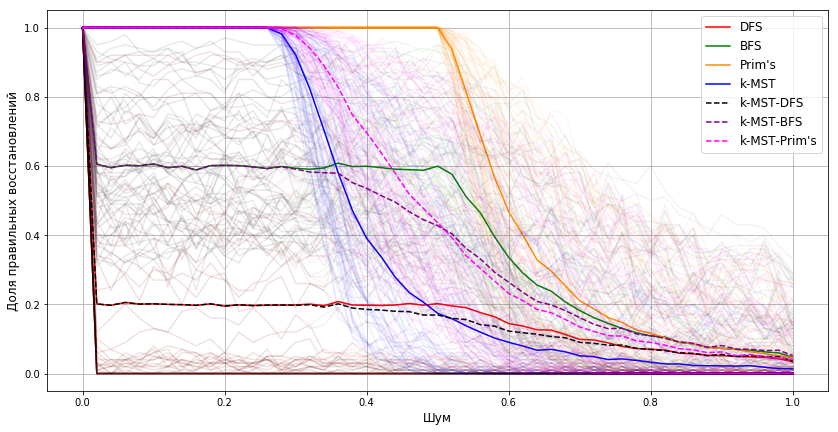

In [11]:
saveas='main_algs_full_alpha006_maxarity_5.pdf'
make_plot_multiple(algs, new_recovered_total_array, repeats, 0.06, 0.0, np.linspace(0.0, 1.0, 51), saveas, (14, 7))

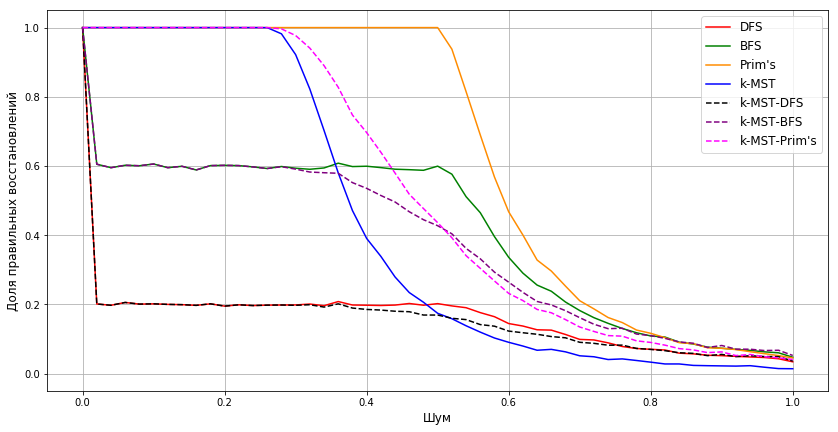

In [12]:
saveas='main_algs_full_alpha000_maxarity_5.pdf'
make_plot_multiple(algs, new_recovered_total_array, repeats, 0.00, 0.0, np.linspace(0.0, 1.0, 51), saveas, (14, 7))

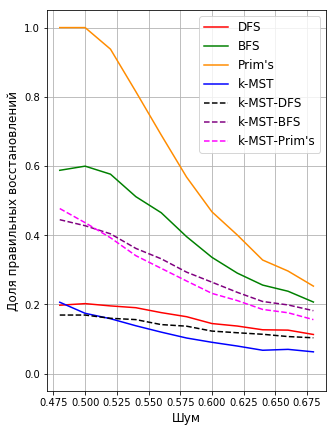

In [13]:
saveas='main_algs_local_alpha000_maxarity_5.pdf'
make_plot_multiple(algs, new_recovered_total_array[:,:,24:35], repeats, 0.0, 0.0, np.linspace(0.48, 0.68, 11), saveas, (5, 7))

In [14]:
(new_recovered_total_array[:,:,25:30].mean(axis=0)*100).round()/100

array([[0.2 , 0.2 , 0.19, 0.18, 0.16],
       [0.6 , 0.58, 0.51, 0.46, 0.4 ],
       [1.  , 0.94, 0.81, 0.69, 0.57],
       [0.17, 0.16, 0.14, 0.12, 0.1 ],
       [0.17, 0.16, 0.16, 0.14, 0.14],
       [0.43, 0.4 , 0.36, 0.33, 0.29],
       [0.44, 0.39, 0.34, 0.3 , 0.27]])

## Эвристики, малые арности

In [15]:
algs = ['greedy_dfs', 'greedy_bfs', 'prim_fast', 'kmst_pure_incor', 'kmst_dfs_incor', 'kmst_bfs_incor', 'kmst_prim_incor']

In [16]:
%%time

repeats = 50

recovered_total_incor = []
for alg in algs:
    np.random.seed(421)
    random.seed(a=472443)
    recovered_total_per_alg = do_exp_multiple(repeats,
                                              1, (5, 20), [alg], 20, 5, np.linspace(0.0, 1.0, 51),
                                              'uniform', 'linear', 1, 5, -1, 0.2, 0.5)
    recovered_total_incor.append(recovered_total_per_alg)


CPU times: user 11min 42s, sys: 3.86 s, total: 11min 46s
Wall time: 11min 40s


In [17]:
print(recovered_total_incor[0].shape)
new_recovered_total_incor_array = np.zeros((recovered_total_incor[0].shape[0], len(algs), recovered_total_incor[0].shape[2]))
for i, rec in enumerate(recovered_total_incor):
    new_recovered_total_incor_array[:, i:i+1, :] = rec.copy()
print(new_recovered_total_incor_array.shape)

(50, 1, 51)
(50, 7, 51)


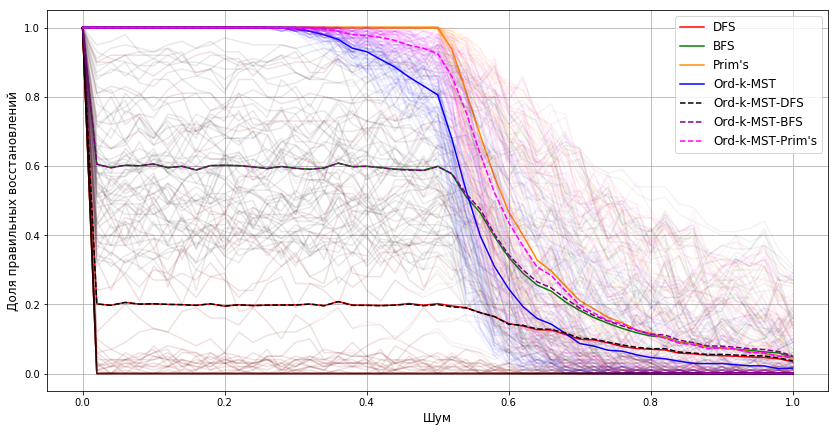

In [18]:
saveas='incor_algs_full_alpha006_maxarity_5.pdf'
make_plot_multiple(algs, new_recovered_total_incor_array, repeats, 0.06, 0.0, np.linspace(0.0, 1.0, 51), saveas, (14, 7), True)

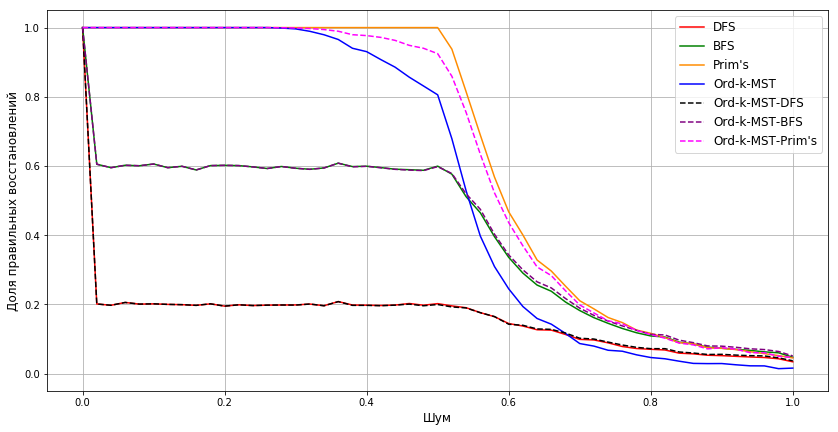

In [19]:
saveas='incor_algs_full_alpha000_maxarity_5.pdf'
make_plot_multiple(algs, new_recovered_total_incor_array, repeats, 0.00, 0.0, np.linspace(0.0, 1.0, 51), saveas, (14, 7), True)

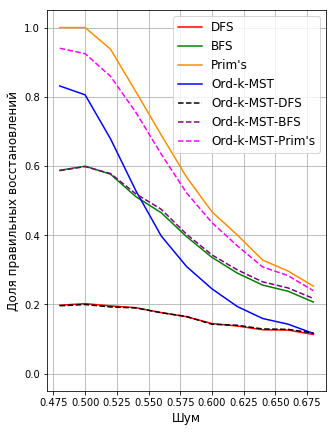

In [20]:
saveas='incor_algs_local_alpha000_maxarity_5.pdf'
make_plot_multiple(algs, new_recovered_total_incor_array[:,:,24:35], repeats, 0.0, 0.0, np.linspace(0.48, 0.68, 11), saveas, (5, 7), True)

In [21]:
(new_recovered_total_incor_array[:,:,25:30].mean(axis=0)*100).round()/100

array([[0.2 , 0.2 , 0.19, 0.18, 0.16],
       [0.6 , 0.58, 0.51, 0.46, 0.4 ],
       [1.  , 0.94, 0.81, 0.69, 0.57],
       [0.81, 0.68, 0.53, 0.4 , 0.31],
       [0.2 , 0.19, 0.19, 0.18, 0.16],
       [0.6 , 0.58, 0.52, 0.47, 0.4 ],
       [0.92, 0.86, 0.76, 0.63, 0.52]])

# Другое


In [738]:
(new_recovered_total_array[:,:,25:30].mean(axis=0)*100).round()/100

array([[0.2 , 0.19, 0.16, 0.13, 0.11],
       [0.59, 0.49, 0.36, 0.25, 0.2 ],
       [1.  , 0.8 , 0.53, 0.36, 0.25],
       [0.01, 0.01, 0.01, 0.01, 0.01],
       [0.79, 0.43, 0.24, 0.15, 0.11],
       [0.91, 0.6 , 0.37, 0.25, 0.18]])

# Время

In [ ]:
algs = ['greedy_dfs', 'greedy_bfs', 'prim', 'kmst-pure', 'kmst-bfs', 'kmst-prim']

In [ ]:
%%time

print(algs[0])

np.random.seed(421)
random.seed(a=472443)

repeats = 100

do_exp_multiple(repeats, 1, (5, 50), list(algs[0]), 20, 5, np.linspace(0.0, 1.0, 51),
                'uniform', 'linear', 1, 2, -1, 0.2, 0.5)

# Temp

In [12]:
import matplotlib.font_manager
flist = matplotlib.font_manager.get_fontconfig_fonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
print(names)
plt.rcParams

['Arial Black', 'Trebuchet MS', 'IBM Plex Serif', 'Latin Modern Roman', 'Noto Serif', 'CMU Bright', 'drmittc12', 'Antykwa Torunska Condensed', 'drmitsc12', 'Caladea', 'Overlock', 'drmscbx8', 'TeX Gyre Pagella', 'Roboto Slab', 'drmui9', 'drml17', 'Source Sans Pro', 'IBM Plex Serif', 'Overlock', 'FreeMono', 'Noto Sans', 'drmuibx14', 'Berenis ADF Pro SC', 'Antykwa Poltawskiego', 'CMU Serif', 'drmuibx24', 'Kurier Cond Medium', 'drmdozit9', 'Mint Spirit', 'IBM Plex Mono', 'drmscbx9', 'Cabin Condensed', 'drmdozsl24', 'Go Mono', 'drmtc9', 'Fira Mono', 'drmui8', 'drmdozb24', 'Source Sans Pro', 'drmuibx17', 'Latin Modern Mono Slanted', 'IBM Plex Mono', 'drmdozsl17', 'Fetamont', 'Gillius ADF No2 Cond', 'Montserrat', 'drmdozb14', 'drmdozitbx11', 'drmdozit8', 'Alegreya Sans', 'Libertinus Serif', 'PT Serif', 'Antykwa Torunska Condensed', 'Iwona Heavy', 'Antykwa Poltawskiego', 'Fetamont', 'CMU Serif', 'TeX Gyre Termes', 'Coelacanth', 'drmdozsl14', 'drminf17', 'drmtc8', 'MnSymbol', 'Amiri', 'Alegreya

In [744]:
the_biggest_recover_with_big_arities = new_recovered_total_array.copy()

In [717]:
the_biggest_recover = new_recovered_total_array.copy()

In [745]:
np.save('with_big_arities', the_biggest_recover_with_big_arities)
np.save('without_big_arities', the_biggest_recover)

In [ ]:
np.array()

In [ ]:
c[list(a)] = 0

In [ ]:
c

In [63]:
# fourier_feat_gen = feature_generators.FourierFG(threshold=20)

# X_fourier = timeseries.ExtractFeatures(data_X,
#     lambda ts: fourier_feat_gen(ts)
# )
# X_fourier.shape
# print(X_fourier)

In [ ]:
b

In [ ]:
[''] * 3

In [4]:
a = [0]

In [120]:
rg = np.random.RandomState(1).normal

In [121]:
rg(size=100)

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
        1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
       -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521,
       -1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
       -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547,
       -0.69166075, -0.39675353, -0.6871727 , -0.84520564, -0.67124613,
       -0.0126646 , -1.11731035,  0.2344157 ,  1.65980218,  0.74204416,
       -0.19183555, -0.88762896, -0.74715829,  1.6924546 ,  0.05080775,
       -0.63699565,  0.19091548,  2.10025514,  0.12015895,  0.61720311,
        0.30017032, -0.35224985, -1.1425182 , -0.34934272, -0.20889423,
        0.58662319,  0.83898341,  0.93110208,  0.28558733,  0.88514116,
       -0.75439794,  1.25286816,  0.51292982, -0.29809284,  0.48851815,
       -0.07557171,  1.13162939,  1.51981682,  2.18557541, -1.39

In [98]:
a 

array([0. , 0. , 0. , 0.1])

In [100]:
a[[1, 2, 3]]

array([0. , 0. , 0.1])

In [287]:
edges = [1, 2, 3, 4, 5, 6]
to_drop = [0, 4, 2]
edges = [e for i, e in enumerate(edges) if i not in to_drop]

In [288]:
edges

[2, 4, 6]

In [14]:
prior_queue = heapq.heapify([])

In [21]:
a = [5, 12, 33, 2, 1]

heapq.heapify(a)

In [22]:
a

[1, 2, 33, 5, 12]

In [376]:
algs = ['greedy_dfs', 'greedy_bfs', 'prim', 'kmst']

#### 1) normal, linear, 1, 2, -1

In [377]:
np.random.seed(421)
random.seed(a=472443)

recovered = do_exp(10, (5, 50), algs, 5, 5, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 1, 2, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


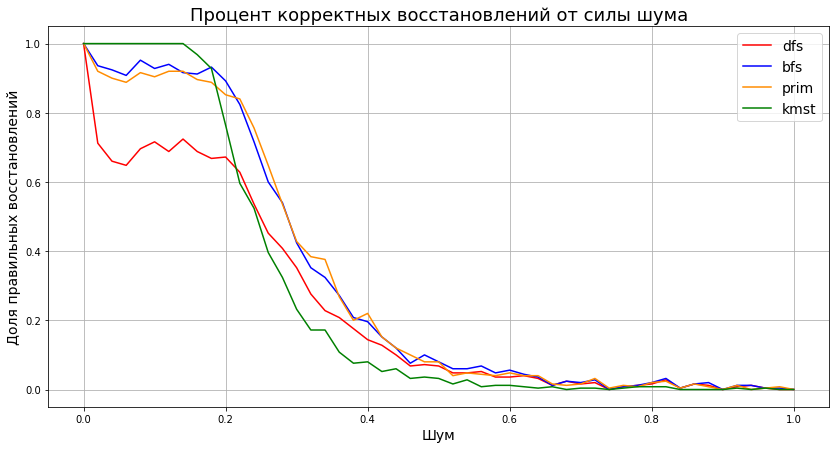

In [378]:
make_plot(algs, recovered)

#### 2) 'normal', 'linear', 2, 2, -1

In [242]:
np.random.seed(421)
random.seed(a=472443)



recovered = do_exp(10, (5, 50), algs, 20, 20, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 2, 2, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


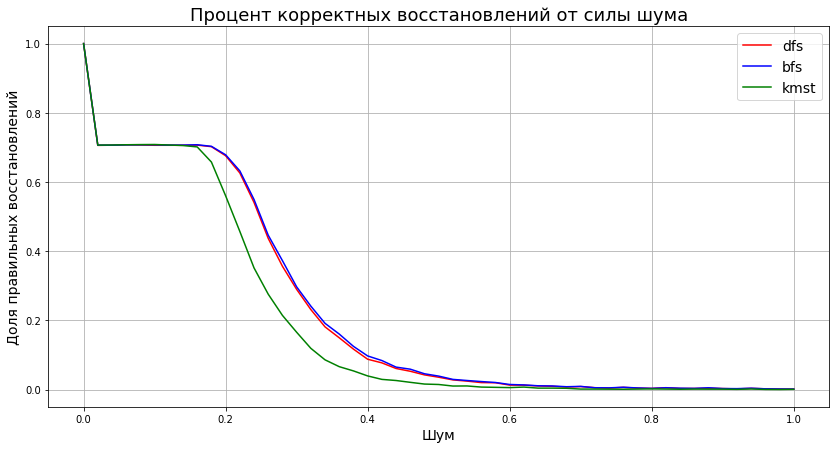

In [244]:
make_plot(algs, recovered)

#### 3) 'normal', 'linear', 1, 5, -1

In [245]:
np.random.seed(421)
random.seed(a=472443)

recovered = do_exp(10, (5, 50), algs, 20, 20, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 1, 5, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


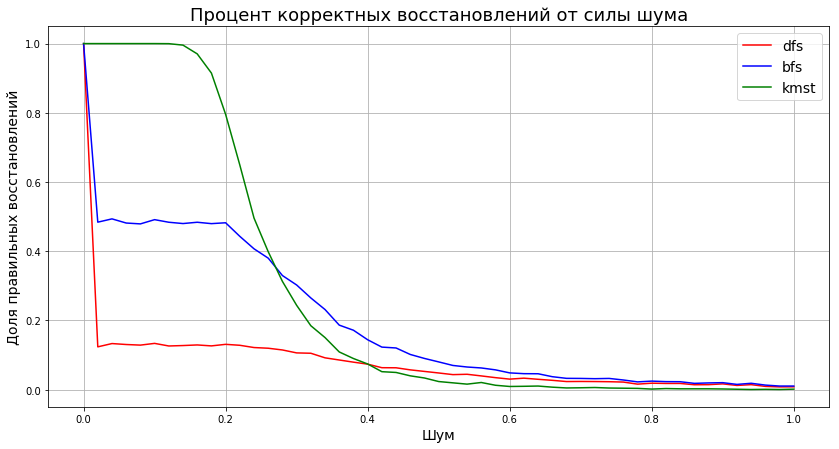

In [246]:
make_plot(algs, recovered)

#### 4) 'normal', 'linear', 1, 3, 2

In [254]:
np.random.seed(421)
random.seed(a=472443)

recovered = do_exp(10, (5, 50), algs, 20, 20, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 2, 3, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


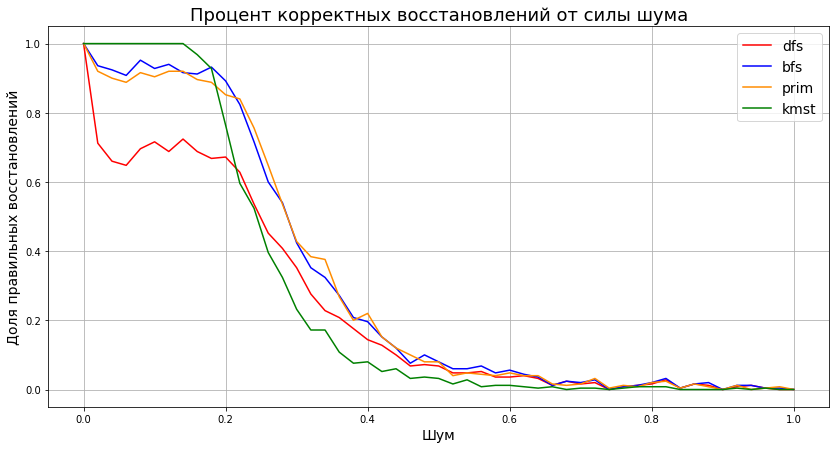

In [383]:
make_plot(algs, recovered)